Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 499kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.93MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.77MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 1/10, Train Loss: 0.5809, Validation Loss: 0.2977, Validation Accuracy: 90.96%
Epoch 2/10, Train Loss: 0.2187, Validation Loss: 0.1690, Validation Accuracy: 95.02%
Epoch 3/10, Train Loss: 0.1551, Validation Loss: 0.1522, Validation Accuracy: 95.34%
Epoch 4/10, Train Loss: 0.1262, Validation Loss: 0.1272, Validation Accuracy: 95.87%
Epoch 5/10, Train Loss: 0.1066, Validation Loss: 0.1172, Validation Accuracy: 96.29%
Epoch 6/10, Train Loss: 0.0871, Validation Loss: 0.1358, Validation Accuracy: 95.94%
Epoch 7/10, Train Loss: 0.0802, Validation Loss: 0.0938, Validation Accuracy: 97.22%
Epoch 8/10, Train Loss: 0.0705, Validation Loss: 0.1059, Validation Accuracy: 96.74%
Epoch 9/10, Train Loss: 0.0599, Validation Loss: 0.1381, Validation Accuracy: 96.02%
Epoch 10/10, Train Loss: 0.0572, Validation Loss: 0.1076, Validation Accuracy: 97.20%


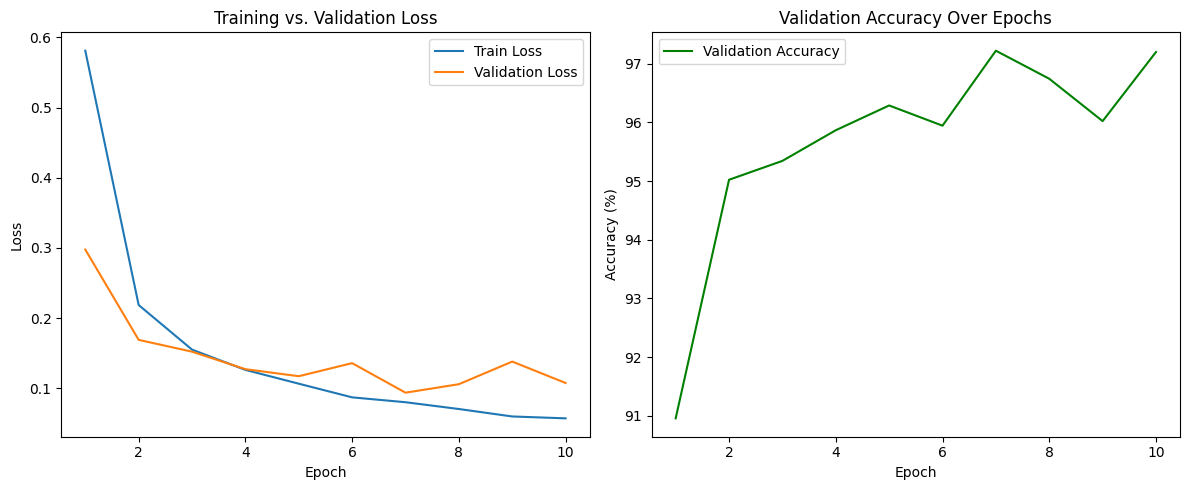

Test Accuracy: 96.76%
Test Loss: 0.1130

Confusion Matrix:
[[857   0   3   1   2   9  16   1   4   3]
 [  0 966   0   0   3   1   0   1   4   1]
 [  1   3 819   3   0   0  10  13   4   0]
 [  1   0  14 880   0  23   0   8  12   3]
 [  0   0   0   0 861   0   4   2   1   2]
 [  1   0   0   4   1 817   5   3   7   3]
 [  1   0   0   0   1  16 882   0   4   0]
 [  1   2   5   0   2   1   0 967   3   4]
 [  0   3   3   2   5   7   2   3 826   7]
 [  2   1   1   1  20   4   0  13   1 833]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       896
           1       0.99      0.99      0.99       976
           2       0.97      0.96      0.96       853
           3       0.99      0.94      0.96       941
           4       0.96      0.99      0.98       870
           5       0.93      0.97      0.95       841
           6       0.96      0.98      0.97       904
           7       0.96      0.98      0.97       985

In [1]:
import torch
import torchvision
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Step 1: Load the MNIST dataset and preprocess
def load_data():
    # Load the MNIST dataset without transforms
    dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True)

    # Extract images and labels as NumPy arrays
    X = dataset.data.numpy()
    y = dataset.targets.numpy()

    # Flatten and normalize the images
    X = X.reshape(X.shape[0], -1) / 255.0
    X = (X - 0.5) / 0.5

    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)

    return X_tensor, y_tensor

# Step 2: Define the simple ANN model with manually initialized weights and biases
class SimpleANN(torch.nn.Module):
    def __init__(self):
        super(SimpleANN, self).__init__()
        self.W1 = torch.nn.Parameter(torch.randn(28*28, 512) * 0.01)
        self.b1 = torch.nn.Parameter(torch.zeros(512))
        self.W2 = torch.nn.Parameter(torch.randn(512, 256) * 0.01)
        self.b2 = torch.nn.Parameter(torch.zeros(256))
        self.W3 = torch.nn.Parameter(torch.randn(256, 128) * 0.01)
        self.b3 = torch.nn.Parameter(torch.zeros(128))
        self.W4 = torch.nn.Parameter(torch.randn(128, 10) * 0.01)
        self.b4 = torch.nn.Parameter(torch.zeros(10))

    def forward(self, x):
        x = torch.matmul(x, self.W1) + self.b1
        x = torch.relu(x)  # ReLU activation
        x = torch.matmul(x, self.W2) + self.b2
        x = torch.relu(x)  # ReLU activation
        x = torch.matmul(x, self.W3) + self.b3
        x = torch.relu(x)  # ReLU activation
        x = torch.matmul(x, self.W4) + self.b4  # No activation here, CrossEntropyLoss handles it
        return x

# Step 3: Train the model with validation
def train_model_with_validation(model, X_train, y_train, X_val, y_val, batch_size, epochs, loss_fn, optimizer):
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                val_loss += loss_fn(outputs, labels).item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct / total * 100)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.2f}%")

    return train_losses, val_losses, val_accuracies

# Step 4: Evaluate the model
def evaluate_model(model, X_test, y_test, batch_size, loss_fn):
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels)) * 100
    avg_loss = total_loss / len(test_loader)
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds)

    return accuracy, avg_loss, cm, report

# Step 5: Visualization functions
def plot_learning_curves(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training vs. Validation Loss')

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Validation Accuracy Over Epochs')

    plt.tight_layout()
    plt.show()

# Step 6: Main program
if __name__ == "__main__":
    # Load and split data
    X, y = load_data()
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Initialize model, loss function, and optimizer
    model = SimpleANN()
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model with validation
    train_losses, val_losses, val_accuracies = train_model_with_validation(
        model, X_train, y_train, X_val, y_val, batch_size=64, epochs=10, loss_fn=loss_fn, optimizer=optimizer
    )

    # Plot training vs. validation loss and validation accuracy
    plot_learning_curves(train_losses, val_losses, val_accuracies)

    # Evaluate the model on test data
    accuracy, avg_loss, cm, report = evaluate_model(model, X_test, y_test, batch_size=64, loss_fn=loss_fn)

    # Display evaluation metrics
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Test Loss: {avg_loss:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(report)
